Deep coadds of all of the COS data to see if we can find a continumm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from astropy.nddata import StdDevUncertainty



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Test one- deep coadds of the x1ds (with RV shift?). If that looks bad, try the x2ds.

In [25]:
def spectra_adder(f_array, e_array, rcs = True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    if rcs:
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux, error


def complicated_spectra_adder(f_array, e_array):
    flux = []
    error = []
    print(len(f_array[0]))
    for i in range(len(f_array[0])):    
        fcol = f_array[:,i]
        # print(len(fcol))
        ecol = e_array[:,i]
        weights = np.zeros(len(fcol))
        for j in range(len(fcol)):
            if ecol[j] != 0.0:
                weights[j] = 1/(ecol[j]**2)
        fi = np.sum(fcol*weights)/np.sum(weights)
        flux.append(fi)
    return flux
                
            
        


In [17]:
# path ='/media/david/5tb_storage1/muscles/all_cos/'
# x1ds = glob.glob('{}*x1dsum.fits'.format(path))
# flts = glob.glob('{}*flt*.fits'.format(path))
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'
cosspecs = glob.glob('{}*/*cos*g1*.fits'.format(path))
print(cosspecs)
# print(flts)

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_hst_cos_gj1132_g130m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_hst_cos_gj1132_g160m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_hst_cos_gj163_g130m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_hst_cos_gj163_g160m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_hst_cos_gj649_g130m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_hst_cos_gj674_g130m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_cos_gj676a_g130m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_hst_cos_gj699_g130m_v10_component-spec.fits', '/media/david/2tb_ext_hd/hddata/mega_musc

In [18]:


# smooth = 5
# for w, f, e in zip([wa, wb],[fa, fb],[ea, eb]):
#     f = convolve(f,Box1DKernel(smooth))
#     e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
#     plt.plot(w, f)
#     plt.plot(w, e)
# plt.ylim(-0.3e-16, 1e-16)
# # plt.xlim(1100, 1150)
# plt.axhline(0, ls='--', c='k', alpha=0.5)

Wow. Fit prominent lines?

In [19]:
# for x in x1ds:
#     hdr = fits.getheader(x, 0)
#     print(hdr['TARGNAME'])
#     print(hdr['CENWAVE'])
#     data = fits.getdata(x, 1)
#     wa, fa, ea = data[1]['WAVELENGTH'], data[1]['FLUX'], data[1]['ERROR']
#     wb, fb, eb = data[0]['WAVELENGTH'], data[0]['FLUX'], data[0]['ERROR']
#     fa = convolve(fa,Box1DKernel(smooth))
#     ea = convolve(ea,Box1DKernel(smooth))/(smooth**0.5)
#     fb = convolve(fb,Box1DKernel(smooth))
#     eb = convolve(eb,Box1DKernel(smooth))/(smooth**0.5)
# #     plt.subplot(131)
# #     plt.plot(wa, fa)
#     plt.plot(wa, ea)
#     plt.xlim(1200, 1210)
#     plt.subplot(132)
#     plt.plot(wb, fb)
#     plt.plot(wb, eb)
#     plt.xlim(1230, 1240)
#     plt.subplot(133)
#     plt.plot(wb, fb)
#     plt.plot(wb, eb)
#     plt.xlim(1330, 1340)
#     plt.plot(wa, fa)
#     plt.plot(wb, fb)
#     plt.show()
#     print(wa[0], wa[-1])
#     print(wb[0], wb[-1])

    


Need to distance scale them first?

In [20]:
params = Table.read('../optical/stellar_parameters.csv')

In [21]:
params

Target,RAJ2000,DEJ2000,Jmag,J_e,Hmag,H_e,Kmag,K_e,Rmag,R_e,spt,L_bol,L_bol_e,Mass,Mass_e,Radius,Radius_e,Teff,Teff_e,parallax,distance,P_rot_d
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64
GJ 1132,153.716027,-47.156796,9.245,0.026,8.666,0.031,8.322,0.027,13.098,0.11,M3.5,1.67e+31,5e+29,0.194,0.005,0.215,0.009,3196,72,83.07,12.03804021,126.59
GJ 676A,262.546646,-51.637012,6.711,0.02,6.082,0.024,5.825,0.029,8.675,0.012,M0,3.404e+32,8.3e+30,0.631,0.017,0.62,0.03,4014,94,63.07,15.85539876,41.2
GJ 15A,4.594036,44.022842,5.252,0.264,4.476,0.2,4.018,0.02,7.9,0.012,M1,8.61e+31,7e+29,0.393,0.009,0.385,0.002,3601,12,280.74,3.562014676,-1.0
GJ 649,254.536873,25.74423,6.448,0.021,5.865,0.02,5.624,0.016,8.685,0.012,M1,1.674e+32,1.7e+30,0.524,0.012,0.531,0.012,3621,41,96.38,10.3755966,-1.0
GJ 163,62.315307,-53.373737,7.948,0.026,7.428,0.04,7.135,0.021,10.734,0.012,M3.5,8.28e+31,2.4e+30,0.405,0.01,0.409,0.017,3460,76,66.59,15.01726986,61.0
GJ 849,332.417906,-4.640765,6.51,0.024,5.899,0.044,5.594,0.017,9.279,0.012,M3.5,1.105e+32,1e+30,0.465,0.011,0.464,0.018,3492,70,113.25,8.830022075,39.2
GJ 674,262.166316,-46.89513,5.711,0.019,5.154,0.033,4.855,0.018,8.337,0.012,M2.5,6.03e+31,1.4e+30,0.353,0.008,0.361,0.012,3404,59,220.24,4.540501271,32.9
GJ 699,269.452044,4.694597,5.244,0.02,4.834,0.034,4.524,0.02,8.298,0.012,M4,1.3e+31,2e+29,0.161,0.004,0.187,0.001,3223,17,548.31,1.823785815,130.4
L 980-5,215.313034,-1.122204,8.948,0.03,8.391,0.031,8.093,0.026,13.02,0.15,M3.5,2.49e+31,8e+29,0.232,0.006,0.25,0.01,3278,74,74.66,13.39405304,92.23


['GJ1132' 'GJ676A' 'GJ15A' 'GJ649' 'GJ163' 'GJ849' 'GJ674' 'GJ699'
 'L980-5' 'LHS2686' 'GJ729' 'TRAPPIST-1']
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_hst_cos_gj1132_g130m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_hst_cos_gj1132_g160m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_hst_cos_gj163_g130m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_hst_cos_gj163_g160m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_hst_cos_gj649_g130m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_hst_cos_gj674_g130m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_cos_gj676a_g130m_v10_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_h

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


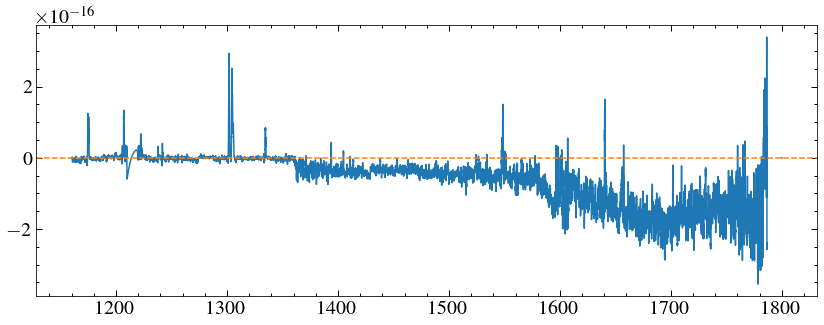

In [33]:
targets = np.array([t.replace(' ', '').upper() for t in np.array(params['Target'])])
print(targets)
# stars  = []
dvs = [40.08741304,-44.46182245,-8.291723875,-3.217962614,36.44496579,-22.96216449,-8.496187662,-124.3703158,16.10168084,5.910544015,12.18051577,-62.55832308]

wnew = np.arange(1160, 1800, 0.01)

allflux = []
allerror = []

smooth = 5
fluxcon = FluxConservingResampler(extrapolation_treatment='zero_fill')

for i, spec in enumerate(cosspecs):
    print(spec)
    star = fits.getheader(spec)['TARGNAME']
    if star == '2MASS-J23062928-0502285':
        star = 'TRAPPIST-1'
    if star == 'L-980-5':
        star = 'L980-5'
    if star == 'LHS-2686':
        star = 'LHS2686'
    arg = np.where(targets == star)[0][0]
    dstar = params['distance'][arg]
    # print(dstar)
    data = fits.getdata(spec, 1)
    w, f, e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    mask = (w > 1160) & ( w < 1210) | (w > 1220) 
    w, f, e = w[mask], f[mask], e[mask]
    # plt.plot(w,f)
    # plt.plot(w, e)
    # plt.show()
    # print(np.diff(w))
    # print(len(e[e < 0]))
    # w, f, e = w[dq==0], f[dq==0], e[dq==0]
    wi = (dvs[arg]*u.km/u.s).to(u.AA,  equivalencies=u.doppler_optical(w*u.AA)).value
    fi = f*(dstar/10)**2 #to 10pc
    ei = e*(dstar/10)**2 #to 10pc
    # plt.plot(wi, fi)
    # plt.plot(wi, ei)
    # plt.show()
    # fi = convolve(fi,Box1DKernel(smooth))
    # ei = convolve(ei,Box1DKernel(smooth))/(smooth**0.5)

# new_spec_fluxcon = fluxcon(input_spec, neww*u.AA)


    # input_spec = Spectrum1D(spectral_axis=(w)*u.AA, flux=f*u.Unit('erg cm-2 s-1 AA-1'),  uncertainty= StdDevUncertainty(e))
    # wi = np.arange(w[0], w[-1]+0.01, 0.01)
    # new_spec_fluxcon = fluxcon(input_spec, wi*u.AA)
    # wi = new_spec_fluxcon.spectral_axis.value
    # fi = new_spec_fluxcon.flux.value
    # ei = (1/(new_spec_fluxcon.uncertainty.array**0.5))

    # start += step
    
    
    
    fi = interp1d(wi, fi, bounds_error=False, fill_value=0)(wnew)
    ei = interp1d(wi, ei, bounds_error=False, fill_value=0)(wnew) #fine as long as res is similar
    # print(len(ei[np.isnan(ei)==True]))
    # plt.plot(wnew, fi)
    # plt.plot(wnew, ei)
    # print(len(ei[ei < 0]))
    # plt.show()
    
    # if spec != '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_hst_cos_gj649_g130m_v10_component-spec.fits':
    allflux.append(fi)
    allerror.append(ei)
# print(allerror)

allflux, allerror = np.array(allflux), np.array(allerror)
# print(allflux)
# fnew, enew = spectra_adder(allflux, allerror, rcs = False)
fnew = complicated_spectra_adder(allflux, allerror)
fnew = convolve(fnew,Box1DKernel(20))
plt.plot(wnew, fnew)
plt.axhline(0, ls ='--', c='C1')
# print(fnew)
# print(enew)
# mask = (wnew < 1210) | (wnew >1220)
# plt.plot(wnew[mask], np.mean(allflux, axis=0)[mask])
    
# plt.yscale('log')
    

    # stars.append(star)
# print(stars)
    # dstar = params['distance'][np.where(targets.upper().replace(' ', '') == star)[0]]
    # print(star, dstar)

In [9]:
# GJ649 , -3.2179626137386097
# GJ1132 , 40.08741304111106
# GJ15A , -8.29172387532275
# GJ163 , 36.44496578836573
# GJ674 , -8.496187662426907
# GJ676A , -44.461822449302915
# GJ699 , -124.3703158406861
# GJ729 , 12.180515773744279
# GJ849 , -22.9621644919636
# L980-5 , 16.10168084165221
# LHS2686 , 5.910544014529296
# TRAPPIST-1 , -62.558323075720324